## Mingu Kim- 5/22/17

# Exploration of Structured Bandit

In [220]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy.stats import norm
import seaborn as sns
sns.set_style("whitegrid")

$$r_t \sim N(\theta(s_t, a_t), \tau^{-1})$$

In [2]:
def sample_r(theta_val):
    return np.random.normal(theta_val, tau ** (-1))

$$\theta(s,a) \sim N(0, \lambda_0^{-1}(s,a))$$

In [3]:
def theta(s, a):
    return np.random.normal(0, lambda_1(s,a) ** (-1))

**Here we assume precisions are the same for all states, actions **
$$\lambda_1(s,a) = \lambda_0$$

In [4]:
def lambda_1(s,a):
    return lambda0

$$\lambda_t(s_t,a_t) = \lambda_{t-1}(s_t,a_t) + \tau$$
$$\lambda_t(s_t, a_t) = \lambda_1(s,a) + (t-1) \tau$$

In [5]:
def lambda_t(t, s, a):
    return (t-1) * tau + lambda_1(s, a)

$$\eta_t = \frac{\tau}{\tau + \lambda_t(s_t,a_t)}$$ 

In [6]:
def eta(t, s, a):
    return tau / (tau + lambda_t(t, s, a))

$$\hat{\theta}_t(s_t,a_t) =\hat{\theta}_{t-1} (s_t,a_t) + \eta_t [r_{t-1} - \hat{\theta}_{t-1}(s_t,a_t)] $$
We also know that $$\hat{\theta}_1(s_t,a_t) = 0.$$

** I used a dictionary to implement my posterior means, so that we can flexibly add (s,a) pairs as needed**

In [160]:
def theta_t(thetas, r, s, a):
    updated_thetas = thetas.copy()
    if (s,a) not in thetas:
        updated_thetas[(s, a)] = [eta(1, s, a) * r, 2]
    else:
        updated_thetas[(s, a)] \
        = [updated_thetas[(s, a)][0] + eta(updated_thetas[(s, a)][1], s, a) * (r - updated_thetas[(s, a)][0]), updated_thetas[(s, a)][1] + 1]
    return updated_thetas

$$P(r_t \mid s_t, a_t) = N(r_t; \hat{\theta}_t (s_t, a_t), \lambda_t(s_t, a_t)^{-1} + \tau^{-1})$$

In [8]:
def likelihood(r, t, s, a, thetas):
    return np.random.normal(norm(thetas.get((s, a), [0, 0])[0], tau ** (-1)).pdf(r) , lambda_t(t,s,a) ** (-1) + tau ** (-1))

$$
  P(s_t = k \mid \textbf{s}_{1:t-1}) =
  \begin{cases}
   \frac{C_k + \omega \mathbb{I}[s_t = s_{t-1}]}{t+\alpha - 1} & \text{if $k \leq K$} \\
   \frac{\alpha}{t+\alpha-1} & \text{if $k = K_1$} 
  \end{cases}
$$
where $\mathbb{I}$[·] = 1 when its argument is true (0 otherwise), $C_k$ is the number of previous trials state $k$
was sampled, and $K$ is the total number of distinct previously sampled states. The concentration
parameter $\alpha > 0$ controls the propensity for sampling new states; the expected number of distinct
states after $t$ trials is $\alpha \ln t$. When $\alpha = 0$, only a single state will be sampled for all trials, and when
α approaches infinity, each trial will be associated with a distinct state. The parameter $\omega$ specifies
the “stickiness” or autocorrelation of states: when stickiness is high, consecutive trials will tend to
sample the same state.

In [9]:
#Takes k, $\omega$, $\alpha$, and visited states
def prior_prob(k,w, alpha, s_list):
    K = len(set(s_list))
    if k <= K - 1:
        return (s_list.count(k) + w * int(k == s_list[-1])) / (len(s_list) + alpha)
    elif k == K:
        return alpha / (len(s_list) + alpha)
    else:
        return "ERROR"

In [174]:
# Gives normalized probabilities of visiting each state
def prior_norm(w, alpha, s_list):
    K = len(set(s_list))
    probs = np.zeros(K + 1)
    for k in range(K+1):
        probs[k] = prior_prob(k,w,alpha, s_list)
    return np.array([float(i)/sum(probs) for i in probs])

$$\DeclareMathOperator*{\argmax}{argmax}$$
$$P(s_t \mid \textbf{a}_{1:t-1}, \textbf{r}_{1:t-1}) \approx P(s_t \mid \textbf{a}_{1:t-1}, \textbf{r}_{1:t-1}, \hat{\textbf{s}}_{1:t-1}), $$

where $\hat{s}_t$ is defined recursively as follows:

$$\hat{s}_t = \argmax_{s_t} P(r_t \mid s_t, \textbf{a}_{1:t}, \textbf{r}_{1:t-1}, \hat{\textbf{s}}_{1:t-1}) P(s_t \mid \hat{\textbf{s}}_{1:t-1})$$

In [11]:
def s_hat(s_list, t, r, a, w, alpha, thetas):
    priors = prior_norm(w, alpha, s_list)
    s_hats = np.array([likelihood(r, t, s, a, thetas) * priors[s] for s in range(len(priors))])
    return np.argmax(s_hats)

In [12]:
def prior_map_est(reward_list, action_list, w, alpha, thetas):
    s_list = [0]
    for i in range(len(reward_list)):
        s_list.append(s_hat(s_list, len(s_list) + 1, reward_list[i], action_list[i], w, alpha, thetas))
    return prior_norm(w, alpha, s_list)

$$b_t(s) \propto P(r_t \mid s_t = s, a_t) P(s_t = s \mid \textbf{a}_{1:t-1}, \textbf{r}_{1:t-1})$$

In [13]:
def posterior(prior, state, action_list, reward_list, w, alpha, thetas):   
    if state > len(prior):
        return 0
    return likelihood(reward_list[-1], len(reward_list), state, action_list[-1], thetas) * prior[state]

$$ \mu_t(a) = \sum_s b_t(s) \hat{\theta}_t(s,a)$$

In [14]:
def mu_t(prior,action, action_list, reward_list, w, alpha, thetas):
    exp_reward = 0
    for state in range(len(prior)):
        exp_reward += posterior(prior, state, action_list, reward_list, w, alpha, thetas) \
        * thetas.get((state, action), [0, 0])[0]
    return exp_reward

$$\pi_t(s) = e^{\beta \mu_{t-1} (a)}$$

In [206]:
def softmax_action(prior, actions, action_list, reward_list, w, alpha, thetas, beta):
    if len(action_list) == 0:
        return np.random.choice(len(actions))
    action_vals = []
    for action in actions:
        action_vals.append(np.exp(beta * mu_t(prior, action, action_list, reward_list, w, alpha, thetas)))
    actions_normed = np.array(action_vals) / sum(action_vals)
    return np.random.choice(len(actions), 1, p=actions_normed)[0]

$$Q_t(a) = \mu_{t-1} (a) + \beta^{-1} \sigma_{t-1}(a)$$

$$\sigma_t(a) = \sqrt{\sum_s b_t(s) [(\hat{\theta}_t(s,a) - \mu_t(s,a))^2 + 1/\lambda_t(s,a)]}$$

$$\pi_t(a) = (1-\epsilon) \mathbb{I}[a=a^{*}] + \frac{\epsilon}{A} (1-\mathbb{I}[a=a^{*}]))$$


In [239]:
def UCB_action(prior, actions, action_list, reward_list, w, alpha, thetas, beta, epsilon):
    if len(action_list) == 0:
        return np.random.choice(len(actions))
    action_vals = []
    Q = []
    for action in actions:
        sigma = 0
        for s in range(len(prior)):
            sigma+= posterior(prior, s, action_list, reward_list, w, alpha, thetas) \
            * ((thetas.get((s, action), [0, 0])[0] - mu_t(prior, action, action_list, reward_list, w, alpha, thetas))**2\
            + 1 / lambda_t(len(reward_list), s, action))
        if sigma > 0:
            sigma = np.sqrt(sigma)
        else:
            sigma = 0
        Q.append(mu_t(prior, action, action_list, reward_list, w, alpha, thetas) + beta ** (-1)* sigma)
    best_action = np.argmax(Q)
    for action in actions:
        if action == best_action:
            action_vals.append(1 - epsilon)
        else:
            action_vals.append(epsilon / len(actions))
    actions_normed = np.array(action_vals) / sum(action_vals)
    return np.random.choice(len(actions), 1, p=actions_normed)[0]

In [141]:
def update_thetas(thetas, r, a, prior):
    updated_thetas = thetas.copy()
    s = np.random.choice(len(prior), p = prior)
    try:
        updated_thetas[(s, a)] \
        = [updated_thetas[(s, a)][0] + eta(updated_thetas[(s, a)][1], s, a) * (r - updated_thetas[(s, a)][0]), updated_thetas[(s, a)][1] + 1]
    except KeyError:
        updated_thetas[(s, a)] = [eta(1, s, a) * r, 2]
    return updated_thetas

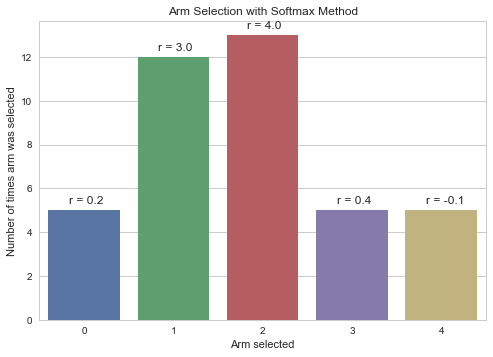

In [260]:
past_actions = []
past_rewards = []
exp_rewards = {}
tau = 3
lambda0 = 5
w = 1
alpha = 1
beta = 0.5
total_actions = range(5)
rewards = [0.2, 3.0, 4.0, 0.4, -0.1]

for i in range(40):
    if len(past_actions) == 0:
        prior = [1]
    else:
        prior = prior_map_est(past_rewards[:-1], past_actions[:-1], w, alpha, exp_rewards)
    curr_action = softmax_action(prior, total_actions, past_actions, past_rewards, w, alpha, exp_rewards, beta)
    curr_reward = np.random.normal(rewards[curr_action], 1.0/tau)
    past_actions.append(curr_action)
    past_rewards.append(curr_reward)
    exp_rewards = update_thetas(exp_rewards, curr_reward, curr_action, prior)
ax = sns.countplot(past_actions)
ax.set(xlabel='Arm selected', ylabel='Number of times arm was selected', title='Arm Selection with Softmax Method')
for p in ax.patches:
    ax.annotate('r = ' + str(rewards[int(p.get_x()+0.4)]), (p.get_x() + 0.23, p.get_height() +0.3))
plt.show()

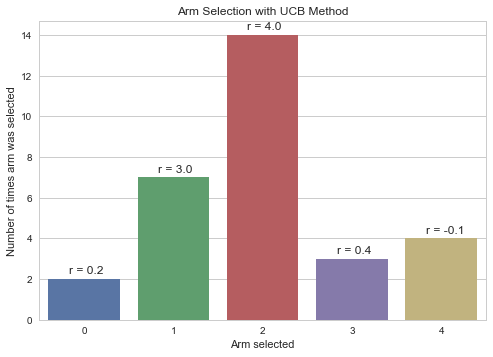

In [265]:
past_actions = []
past_rewards = []
exp_rewards = {}
tau = 3
lambda0 = 5
w = 1
alpha = 1
beta = 0.5
total_actions = range(5)
rewards = [0.2, 3.0, 4.0, 0.4, -0.1]
epsilon = 1
inc = 0.05
for i in range(30):
    if len(past_actions) == 0:
        prior = [1]
    else:
        prior = prior_map_est(past_rewards[:-1], past_actions[:-1], w, alpha, exp_rewards)
    curr_action = UCB_action(prior, total_actions, past_actions, past_rewards, w, alpha, exp_rewards, beta, epsilon)
    curr_reward = np.random.normal(rewards[curr_action], 1.0/tau)
    past_actions.append(curr_action)
    past_rewards.append(curr_reward)
    exp_rewards = update_thetas(exp_rewards, curr_reward, curr_action, prior)
    if epsilon > inc:
        epsilon -= inc
ax = sns.countplot(past_actions)
ax.set(xlabel='Arm selected', ylabel='Number of times arm was selected', title='Arm Selection with UCB Method')
for p in ax.patches:
    ax.annotate('r = ' + str(rewards[int(p.get_x()+0.4)]), (p.get_x() + 0.23, p.get_height() +0.25))
plt.show()